<h1>Exploratory Data Analysis</h1>

In [1]:
import re
from nltk.probability import FreqDist
from matplotlib import ticker
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from nltk import pos_tag, FreqDist
from nltk.corpus import wordnet as wordnet
import contractions
import seaborn as sns
from keras.callbacks import ModelCheckpoint
import tqdm
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from textblob import TextBlob
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, classification_report, 
    precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras import layers
from keras.models import Sequential
#from __future__ import division, print_function
#from gensim import models
#from keras.models import Model
#import os
#import collections
#import re
#import string

In [5]:
def wordnet_pos_code(tag):
    '''Translation from nltk tags to Wordnet code'''
    if tag.startswith('NN'):
        return wordnet.NOUN
    elif tag.startswith('VB'):
        return wordnet.VERB
    elif tag.startswith('JJ'):
        return wordnet.ADJ
    elif tag.startswith('RB'):
        return wordnet.ADV
    else:
        return None


In [2]:
#Load and parse data

train_df = pd.read_csv('//Users//datdao//Downloads//archive//train.txt', sep=";", header=None, names=['text','emotion'])
test_df = pd.read_csv('//Users//datdao//Downloads//archive//test.txt', sep=";", header=None, names=['text','emotion'])
val_df = pd.read_csv('//Users//datdao//Downloads//archive//val.txt', sep=";", header=None, names=['text','emotion'])

In [3]:
#Checking null values

train_df.info()
print()
test_df.info()
print()
val_df.info()
print()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     16000 non-null  object
 1   emotion  16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     2000 non-null   object
 1   emotion  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     2000 non-null   object
 1   emotion  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB



In [ ]:
train_df

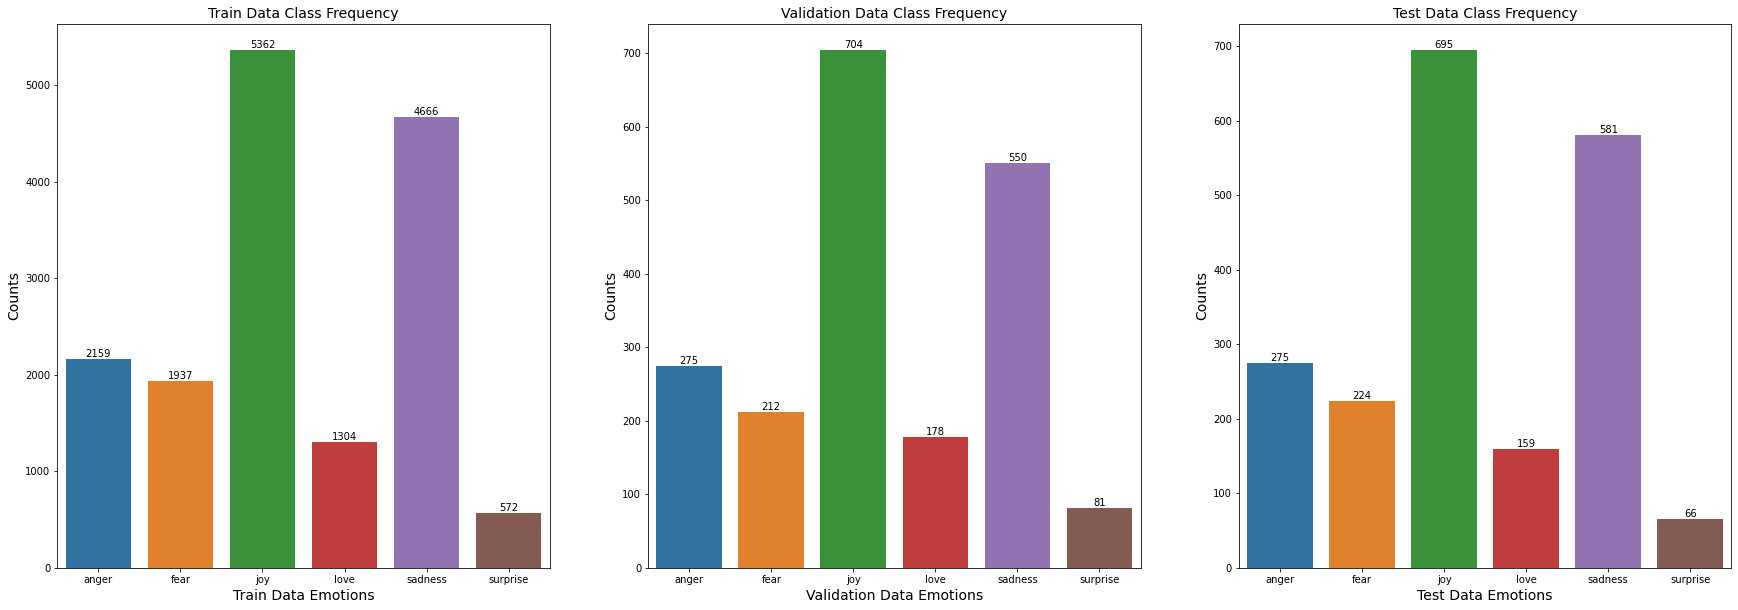

In [21]:
#Checking for distribution (data balance)

data = {'Train Data': train_df, 'Validation Data': val_df, 'Test Data': test_df}
bar, ax = plt.subplots(1,3, figsize=(30, 10))
emo_order = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

    
for index, datum in enumerate(data):
    sns.countplot(ax = ax[index],x = 'emotion', data = data[datum], order=emo_order)
    ax[index].set_title(datum +' Class Frequency', size=14)
    ax[index].set_ylabel('Counts', size=14)
    ax[index].set_xlabel(datum +' Emotions', size=14)
    ax[index].bar_label(ax[index].containers[0])
plt.show()




In [6]:
# Preprocessing: lower cases, remove non-text elements & stopwords, remove contractions, and tokenize data

lm = WordNetLemmatizer()

stoplist = ['feel', 'felt', 'feeling', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your',
            'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
            'she', 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',
            'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is',
            'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',
            'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for',
            'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below',
            'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
            'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most',
            'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'can', 'will',
            'just', 'should', 'now', 'href',  'http', 'www', 'img', 'src',]


def data_prep(df):
    corpus = []
    for i in df:
        item = re.sub("[^a-zA-Z]"," ",str(i))
        item = contractions.fix(item)
        item = item.lower() 
        item = item.split()
        pos_tagging = pos_tag([i for i in item if i not in set(stoplist)])
        for word in pos_tagging:
            pos = wordnet_pos_code(word[1])
            if pos is not None:
                item = [lm.lemmatize(word, pos=pos) for word in item if word not in set(stoplist)]
        corpus.append(' '.join(str(x) for x in item))
    return corpus
        
train_df['text_prep'] = data_prep(train_df['text'])
test_df['text_prep'] = data_prep(test_df['text'])
val_df['text_prep'] = data_prep(val_df['text'])

def txt_tokenizer(df):
    tokens = word_tokenize(df)
    return tokens

train_df['token'] = train_df['text_prep'].apply(txt_tokenizer)
test_df['token'] = test_df['text_prep'].apply(txt_tokenizer)
val_df['token'] = val_df['text_prep'].apply(txt_tokenizer)

In [7]:
def get_wf(text):
    return text.str.split(expand=True).stack().value_counts()

word_freq = dict(get_wf(train_df.text_prep))

word_freq

{'not': 3134,
 'like': 2997,
 'get': 1289,
 'make': 1226,
 'go': 1127,
 'know': 1039,
 'think': 983,
 'time': 978,
 'really': 942,
 't': 897,
 'want': 896,
 'little': 736,
 'love': 725,
 'would': 717,
 'day': 675,
 'thing': 672,
 'people': 664,
 'one': 647,
 'say': 623,
 'still': 597,
 'even': 596,
 'life': 585,
 'way': 528,
 'could': 524,
 'need': 521,
 'something': 514,
 'good': 503,
 'much': 496,
 's': 474,
 'work': 470,
 'see': 460,
 'm': 448,
 'start': 444,
 'no': 442,
 'come': 439,
 'look': 423,
 'take': 417,
 'back': 414,
 'try': 410,
 'bite': 410,
 'pretty': 394,
 'don': 393,
 'well': 389,
 'cannot': 378,
 'leave': 356,
 'always': 355,
 'find': 355,
 'right': 353,
 'friend': 340,
 'year': 337,
 'also': 337,
 'help': 337,
 'today': 332,
 'write': 320,
 'give': 317,
 'around': 315,
 'tell': 295,
 'kind': 284,
 'long': 281,
 'though': 274,
 'never': 264,
 'lot': 264,
 'use': 259,
 'someone': 259,
 'every': 254,
 'keep': 250,
 'happy': 250,
 'read': 244,
 'quite': 238,
 'enough': 2

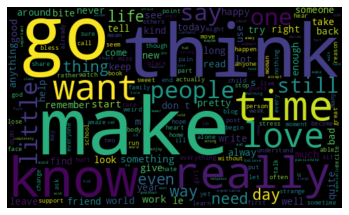

In [8]:
all_words = ' '.join([line for line in train_df['text_prep']])
word_cloud = WordCloud(width=500, height=300, random_state=21, max_font_size=119).generate(all_words)
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()


In [ ]:

c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,3))
# matrix of ngrams
ngrams = c_vec.fit_transform(train_df.text_prep)
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram'})

df_ngram[:20]

In [ ]:
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(3,4))
# matrix of ngrams
ngrams = c_vec.fit_transform(train_df.text_prep)
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'trigram'})

df_ngram[:20]

In [ ]:
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(4,5))
# matrix of ngrams
ngrams = c_vec.fit_transform(train_df.text_prep)
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'four-gram'})

df_ngram[:20]

In [ ]:

c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(5,6))
# matrix of ngrams
ngrams = c_vec.fit_transform(train_df.text_prep)
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'five-gram'})

df_ngram[:20]

In [9]:
from sklearn.preprocessing import LabelEncoder

# data standardization & encoder: replacing String objects as labels with integer values
lb = LabelEncoder()
train_df["encoded_train_label"] = lb.fit_transform(train_df["emotion"])
val_df["encoded_val_label"] = lb.transform(val_df["emotion"])
test_df["encoded_test_label"] = lb.transform(test_df["emotion"])

In [ ]:
train_df["encoded_train_label"]

In [10]:
# view encoded label
train_df[['emotion', 'encoded_train_label']].drop_duplicates(keep='first').sort_values(by=['encoded_train_label'])


,emotion,encoded_train_label
2,anger,0
7,fear,1
8,joy,2
3,love,3
0,sadness,4
6,surprise,5


In [11]:
def manual_encoder(text):
    negative = ['sadness', 'anger', 'fear']
    return 0 if text in negative else 1 

train_df['emo_label'] = train_df['emotion'].apply(manual_encoder)
test_df['emo_label'] = test_df['emotion'].apply(manual_encoder)
val_df['emo_label'] = val_df['emotion'].apply(manual_encoder)


0    8762
1    7238
Name: emo_label, dtype: int64


/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='emo_label', ylabel='count'>

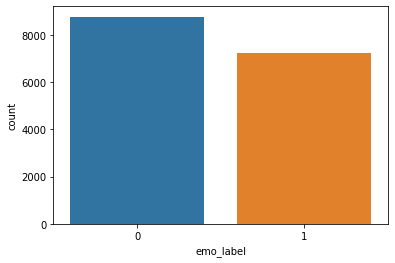

In [12]:
print(train_df.emo_label.value_counts())
sns.countplot(train_df.emo_label)

In [13]:
train_df["encoded_emo_label"] = lb.fit_transform(train_df["emo_label"])
val_df["encoded_emo_label"] = lb.transform(val_df["emo_label"])
test_df["encoded_emo_label"] = lb.transform(test_df["emo_label"])

In [ ]:
train_df

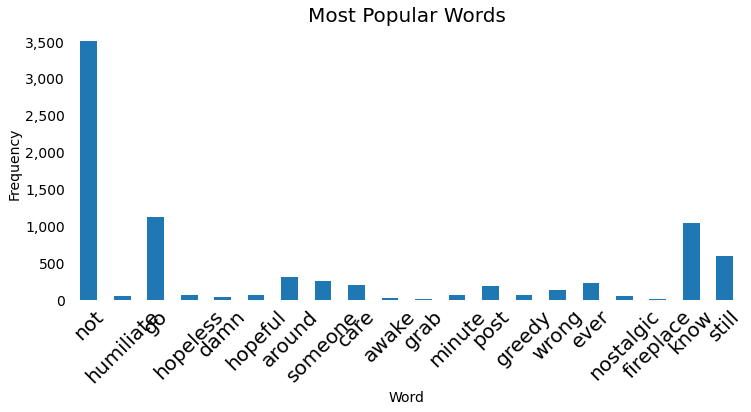

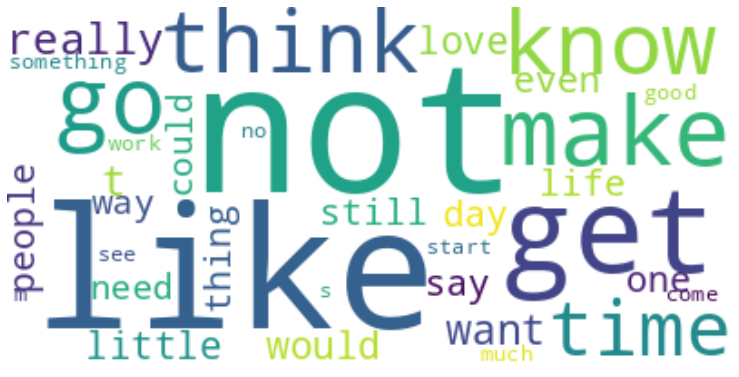

In [14]:
word_list =[]
for i, row in train_df.iterrows():
    for word in row['token']:
            word_list.append(word)
fdist = FreqDist(word_list)

df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
df_fdist.columns = ['Frequency']
df_fdist.index
chart = df_fdist.head(20).plot(kind='bar', fontsize=14, figsize=(12, 5))
plt.title("Most Popular Words", fontsize=20)
chart.set_xlabel("Word", fontsize=14)
chart.set_ylabel("Frequency", fontsize=14)
chart.tick_params(bottom=False, left=False, top=False, right=False)
for key, spine in chart.spines.items():
    spine.set_visible(False)
plt.grid(False)
plt.xticks(fontsize=20)
chart.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
chart.tick_params(axis='x', rotation=45 )
chart.get_legend().remove()
plt.show(chart)

#Create word cloud
wordcloud = WordCloud(max_words=35, max_font_size=100, margin=0, background_color = "white")
wordcloud.generate_from_frequencies(frequencies=df_fdist['Frequency'].to_dict())
plt.figure(figsize=(13,13), )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



In [ ]:
train_pos = train_df[train_df['emo_label'] == 1]
train_pos = train_pos['text']
train_neg = train_df[train_df['emo_label'] == 0]
train_neg = train_neg['text']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords=stoplist,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

In [ ]:
train_df[['emotion', 'encoded_train_label']].drop_duplicates(keep='first')

In [ ]:

pos_normal_words = ' '.join(str(x) for x in train_pos)
pos_normal_words = contractions.fix(pos_normal_words)
pos_normal_words = pos_normal_words.lower() 
pos_normal_words = pos_normal_words.split()
pos_tagged_words = pos_tag([word for word in pos_normal_words if word not in stoplist])

pos_words = []

for word in pos_tagged_words:
    pos = wordnet_pos_code(word[1])

    if pos is not None:
        pos_words.append((lm.lemmatize(word[0], pos=pos), word[1]))

pos_fdist = FreqDist(pos_words)



neg_normal_words = ' '.join(str(x) for x in train_neg)
neg_normal_words = contractions.fix(neg_normal_words)
neg_normal_words = neg_normal_words.lower() 
neg_normal_words = neg_normal_words.split()

neg_tagged_words = pos_tag([word for word in neg_normal_words if word not in stoplist])

neg_words = []

for word in neg_tagged_words:
    pos = wordnet_pos_code(word[1])
    if pos is not None:
        neg_words.append((lm.lemmatize(word[0], pos=pos), word[1]))

neg_fdist = FreqDist(neg_words)




In [ ]:
pos_nouns = []
pos_verbs = []
pos_adjectives = []
pos_adverbs = []

for word, pos in pos_words:
    if pos.startswith('NN') : 
        pos_nouns.append(word)
    elif pos.startswith('VB'):
        pos_verbs.append(word)
    elif pos.startswith('JJ'):
        pos_adjectives.append(word)
    elif pos.startswith('RB'):
        pos_adverbs.append(word)

pos_nouns_fdist = FreqDist(pos_nouns)
pos_verbs_fdist = FreqDist(pos_verbs)
pos_adjectives_fdist = FreqDist(pos_adjectives)
pos_adverbs_fdist = FreqDist(pos_adverbs)

print("Positive Nouns:\n", pos_nouns_fdist.most_common(50))
print("Positive Verbs:\n", pos_verbs_fdist.most_common(50))
print("Positive Adjectives:\n", pos_adjectives_fdist.most_common(50))
print("Positive Adverbs:\n", pos_adverbs_fdist.most_common(50))

In [ ]:
neg_nouns = []
neg_verbs = []
neg_adjectives = []
neg_adverbs = []

for word, pos in neg_words:
    if pos.startswith('NN') : 
        neg_nouns.append(word)
    elif pos.startswith('VB'):
        neg_verbs.append(word)
    elif pos.startswith('JJ'):
        neg_adjectives.append(word)
    elif pos.startswith('RB'):
        neg_adverbs.append(word)

neg_nouns_fdist = FreqDist(neg_nouns)
neg_verbs_fdist = FreqDist(neg_verbs)
neg_adjectives_fdist = FreqDist(neg_adjectives)
neg_adverbs_fdist = FreqDist(neg_adverbs)

print("Nouns:\n", neg_nouns_fdist.most_common(50))
print("Verbs:\n", neg_verbs_fdist.most_common(50))
print("Adjectives:\n", neg_adjectives_fdist.most_common(50))
print("Adverbs:\n", neg_adverbs_fdist.most_common(50))

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

tfidf_vectorizer = TfidfVectorizer(stop_words=stoplist, ngram_range=(3,4))
lda = LatentDirichletAllocation(n_components=3)
pipe = make_pipeline(tfidf_vectorizer, lda)
pipe.fit(train_df['text_prep'])
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
print_top_words(lda, tfidf_vectorizer.get_feature_names(), n_top_words=3)

In [ ]:
from sklearn.decomposition import NMF

tfidf_vectorizer = TfidfVectorizer(stop_words=stoplist, ngram_range=(2,3))
nmf = NMF(n_components=3)
pipe = make_pipeline(tfidf_vectorizer, nmf)
pipe.fit(train_df['text_prep'])
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
print_top_words(nmf, tfidf_vectorizer.get_feature_names(), n_top_words=3)

<h1>CNN BiLSTM Emotion Classification</h1>

In [ ]:
x_train, x_test, y_train, y_test = train_df["text_prep"], val_df["text_prep"], train_df["encoded_train_label"], val_df["encoded_val_label"]

In [ ]:
EPOCHS= 30
act= "swish"
opt= tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
tokenizer = Tokenizer()

#Updates internal vocabulary based on a list of texts. 
#This method creates the vocabulary index based on word frequency. 
#it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).
tokenizer.fit_on_texts(x_train)

#Transforms each text in texts to a sequence of integers. Basically if you had a sentence, it would assign an integer to each word from your sentence.
#It basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.
X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)
TEST = tokenizer.texts_to_sequences(test_df["text_prep"]) 

vocab_size = len(tokenizer.word_index) + 1


In [ ]:
vocab_size

In [ ]:
# dictionary mapping words to their respective index.
tokenizer.word_index

In [ ]:
X_train

In [ ]:
aaaa = [[1, 547],[5, 393, 705, 443, 52, 60, 87, 968]]
tokenizer.sequences_to_texts(aaaa)


In [ ]:
#maxlen: max length of one review for the training

lens_train = [len(i) for i in X_train]
lens_test = [len(i) for i in X_test]
lens = lens_train + lens_test

maxlen = np.max(lens)

print('Max len:', maxlen)

In [ ]:
# padding so all the inputs have the same length

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
TEST = pad_sequences(TEST, padding='post', maxlen=maxlen)

In [ ]:
X_train[1]

In [ ]:
#one hot encoding
dummy_y_test = np_utils.to_categorical(y_test)
dummy_y_train = np_utils.to_categorical(y_train)

In [ ]:
# embedding matrix: list of all words and their corresponding embeddings.
#all the words which are not in the GloVe dictionary being assigned a zero vector.
embedding_index = {}
def get_embedding_vectors(tokenizer, dim=300):
#   embedding_index = {}
    with open('//Users//datdao//Downloads//glove.6B//glove.6B.300d.txt','r') as f:
        for line in tqdm.tqdm(f, "Reading GloVe"):
            values = line.split()
            word = ''.join(values[:-300])
            vectors = np.asarray(values[-300:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector
          
    return embedding_matrix

In [ ]:
#read glove

embedding_matrix = get_embedding_vectors(tokenizer)

In [ ]:
embedding_matrix.shape

In [ ]:
# representing words such that words with the same/similar meaning have a similar representation (word vector).
print(embedding_index['feel'].shape)

In [ ]:
#Choose embedding dimension to suit the GloVE 300d embedding
embedding_dim = 300


In [ ]:
# the model with embedding layers that map the words to their embedding vectors from the embedding matrix

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights = [embedding_matrix], input_length=maxlen))
model.add(layers.Dropout(0.6)) 
model.add(layers.Conv1D(filters=32, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.6))
model.add(layers.Conv1D(filters=32, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.6))
model.add(layers.Bidirectional(layers.LSTM(256, recurrent_dropout=0.3)))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(256,activation=act)) 
model.add(layers.Dropout(0.6)) 
model.add(layers.Dense(6, activation="softmax"))
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

In [ ]:
checkpoint_filepath = './Checkpoint/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=2,
    mode='min', restore_best_weights=True)

In [ ]:
history = model.fit(X_train, dummy_y_train, epochs=EPOCHS, verbose=2, validation_data=(X_test, dummy_y_test), batch_size=128, callbacks=[model_checkpoint_callback]) 
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=0)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=0)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
PlotGraph(history)

In [ ]:
model.load_weights(checkpoint_filepath)


In [ ]:
predict = model.predict(TEST)
predict_class = np.argmax(predict, axis=1)
predict_class = np.array(predict_class)
predict_class


In [ ]:
cm = confusion_matrix(test_df["encoded_test_label"], predict_class)
df_cm = pd.DataFrame(cm, index=["anger", "fear", "joy", "love", "sadness", "surprise"], columns=["anger", "fear", "joy", "love", "sadness", "surprise"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,annot=True, fmt ="d")
plt.title('Emotion Classification Confusion Matrix')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_df["encoded_test_label"], predict_class, target_names =["anger", "fear", "joy", "love", "sadness", "surprise"]))


print("Accuracy:", accuracy_score(test_df["encoded_test_label"], predict_class))

print("Recall:", recall_score(test_df["encoded_test_label"], predict_class, average='weighted'))

print("Precision:", precision_score(test_df["encoded_test_label"], predict_class, average='weighted'))

print("F1-score:", f1_score(test_df["encoded_test_label"], predict_class, average='weighted'))


In [ ]:
tf.keras.backend.clear_session()

<h1>Sentiment Classification</h1>
<h1>CNN-BiLSTM with GloVe Embedding</h1>

In [ ]:
x_train, x_test, y_train, y_test = train_df["text_prep"], val_df["text_prep"], train_df["encoded_emo_label"], val_df["encoded_emo_label"]
                                                                                                 
                                                                                                 
                                                                                                 
                                                                                                 
                                                                                                 

In [ ]:
dummy_y_test = np_utils.to_categorical(y_test)
dummy_y_train = np_utils.to_categorical(y_train)

In [ ]:
# the model with embedding layers that map the words to their embedding vectors from the embedding matrix

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights = [embedding_matrix], input_length=maxlen, trainable=False))
model.add(layers.Dropout(0.3)) 
model.add(layers.Conv1D(filters=32, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(filters=32, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(256, recurrent_dropout=0.3)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256,activation=act)) 
model.add(layers.Dropout(0.3)) 
model.add(layers.Dense(2, activation="softmax"))
model.compile(optimizer=opt, loss="binary_crossentropy",metrics=["accuracy"])
model.summary()



In [ ]:
checkpoint_filepath = './Checkpoint/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=2,
    mode='min', restore_best_weights=True)

In [ ]:
dummy_y_train

In [ ]:
history = model.fit(X_train, dummy_y_train, epochs=EPOCHS, verbose=2, validation_data=(X_test, dummy_y_test), batch_size=128, callbacks=[early_stopping, model_checkpoint_callback], shuffle=True) 
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=0)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=0)
print("Testing Accuracy:  {:.4f}".format(accuracy))


In [ ]:
model.evaluate(X_test, dummy_y_test, verbose=0)

In [ ]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
PlotGraph(history)



In [ ]:
TEST_SENTIMENT = tokenizer.texts_to_sequences(test_df["text_prep"]) 
TEST_SENTIMENT = pad_sequences(TEST_SENTIMENT, padding='post', maxlen=maxlen)

predict = model.predict(TEST_SENTIMENT)
predict_class = np.argmax(predict, axis=1)
predict_class = np.array(predict_class)
predict_class

In [ ]:
dummy_y_test

In [ ]:
cm = confusion_matrix(test_df["encoded_emo_label"], predict_class)
cm

In [ ]:
df_cm = pd.DataFrame(cm, index=["negative", "positive"], columns=["negative", "positive"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,annot=True, fmt ="d")
plt.title('Sentiment Classification Confusion Matrix')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')

In [ ]:
print('\n###### classification report ######\n')
print(classification_report(test_df["encoded_emo_label"], predict_class, target_names =["negative", "positive"]))

print("Accuracy:", accuracy_score(test_df["encoded_emo_label"], predict_class))

print("Recall:", recall_score(test_df["encoded_emo_label"], predict_class, average='weighted'))

print("Precision:", precision_score(test_df["encoded_emo_label"], predict_class, average='weighted'))

print("F1-score:", f1_score(test_df["encoded_emo_label"], predict_class, average='weighted'))

print("ROC AUC score:",roc_auc_score(test_df["encoded_emo_label"], predict_class, average='weighted'))

<h1>Multinominal Naives Bayes Classifier</h1>

In [27]:
cv = CountVectorizer(ngram_range=(1,2))
x_train = cv.fit_transform(train_df['text_prep'])
y_train = train_df['encoded_emo_label']
x_test = cv.transform(test_df['text_prep'])
y_test = test_df['encoded_emo_label']

In [ ]:
y_train

In [ ]:
print(cv.vocabulary_)

In [28]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
# make prediction on testing data

y_pred_test_mnb = mnb.predict(x_test)
y_predprob_mnb = mnb.predict_proba(x_test)





Text(69.0, 0.5, 'Predicted Class')

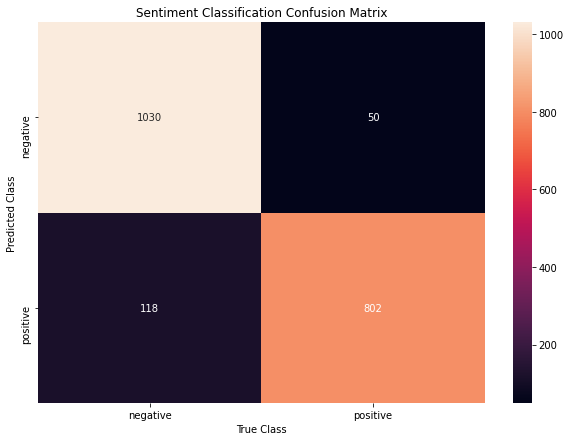

In [29]:
matrix = confusion_matrix(y_test,y_pred_test_mnb)
plt.figure(figsize = (10,7))
sns.heatmap(matrix,annot=True, fmt ="d", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.title('Sentiment Classification Confusion Matrix')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')

In [30]:
print('\n###### classification report ######\n')

print(classification_report(y_test, y_pred_test_mnb, target_names =["negative", "positive"]))

print("Accuracy:", accuracy_score(y_test, y_pred_test_mnb))

print("Recall:", recall_score(y_test, y_pred_test_mnb))

print("Precision:", precision_score(y_test, y_pred_test_mnb))

print("F1-score:", f1_score(y_test, y_pred_test_mnb))

print("ROC AUC score:",roc_auc_score(y_test, y_pred_test_mnb))



###### classification report ######

              precision    recall  f1-score   support

    negative       0.90      0.95      0.92      1080
    positive       0.94      0.87      0.91       920

    accuracy                           0.92      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.92      0.92      0.92      2000

Accuracy: 0.916
Recall: 0.8717391304347826
Precision: 0.9413145539906104
F1-score: 0.9051918735891648
ROC AUC score: 0.9127214170692431


In [31]:
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(cv.get_feature_names(), mnb.coef_[0])}

print("Top positive features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]


Top positive features:


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


[('like', -4.992),
 ('not', -5.069),
 ('make', -5.857),
 ('get', -5.938),
 ('go', -6.047),
 ('love', -6.103),
 ('time', -6.156),
 ('really', -6.192),
 ('think', -6.217),
 ('know', -6.243)]

In [32]:
# most of the words are reliable evidence of indicating negative sentiments
print("Top negative features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]

Top negative features:


[('aa', -12.285),
 ('aa full', -12.285),
 ('aa meet', -12.285),
 ('aaaaand', -12.285),
 ('aaaaand another', -12.285),
 ('aac', -12.285),
 ('aac kind', -12.285),
 ('aaron', -12.285),
 ('aaron friend', -12.285),
 ('abandon angry', -12.285)]

In [ ]:
all_training_words = [word for tokens in train_df["token"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in train_df["token"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))


In [ ]:
all_test_words = [word for tokens in test_df["token"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in test_df["token"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))


In [ ]:
all_training_words

In [ ]:
y_train_2 = train_df['encoded_train_label']
y_test_2 = test_df['encoded_test_label']


mnb.fit(x_train, y_train_2)

# make prediction on testing data

y_pred_test_mnb = mnb.predict(x_test)
y_predprob_mnb = mnb.predict_proba(x_test)



In [ ]:
matrix_mnb_2 = confusion_matrix(y_test_2, y_pred_test_mnb)
df_cm_mnb_2 = pd.DataFrame(matrix_mnb_2, index=["anger", "fear", "joy", "love", "sadness", "surprise"], columns=["anger", "fear", "joy", "love", "sadness", "surprise"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_mnb_2,annot=True, fmt ="d")
plt.title('Sentiment Classification Confusion Matrix')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')

In [ ]:
print(classification_report(y_test_2, y_pred_test_mnb,target_names = ["anger", "fear", "joy", "love", "sadness", "surprise"])
)

print("Accuracy:", accuracy_score(y_test_2, y_pred_test_mnb))

print("Recall:", recall_score(y_test_2, y_pred_test_mnb, average='weighted'))

print("Precision:", precision_score(y_test_2, y_pred_test_mnb,average='weighted'))

print("F1-score:", f1_score(y_test_2, y_pred_test_mnb, average='weighted'))

<h1>Logistic Regression</h1>

In [22]:
x_train = cv.fit_transform(train_df['text_prep'])
y_train = train_df['encoded_emo_label']
x_test = cv.transform(test_df['text_prep'])
y_test = test_df['encoded_emo_label']

# fit a logistic regression classifier on the training data use default settings
lr = LogisticRegression()
lr.fit(x_train, y_train)

# make prediction on testing data
y_pred_test_lr = lr.predict(x_test)
y_predprob_lr = lr.predict_proba(x_test)




Text(69.0, 0.5, 'Predicted Class')

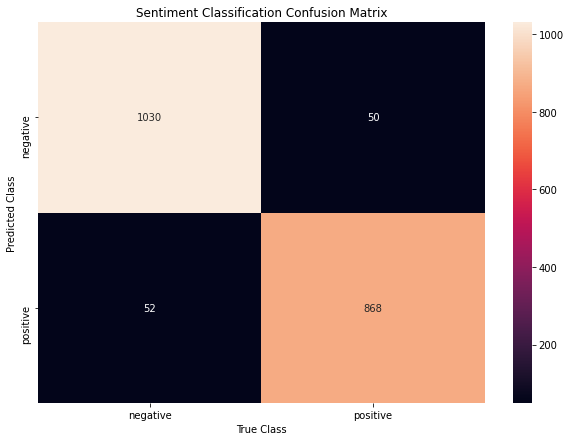

In [23]:
matrix_lr = confusion_matrix(y_test,y_pred_test_lr)
plt.figure(figsize = (10,7))
sns.heatmap(matrix_lr,annot=True, fmt ="d", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.title('Sentiment Classification Confusion Matrix')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')

In [24]:
print(classification_report(y_test, y_pred_test_lr, target_names =["negative", "positive"]))

print("Accuracy:", accuracy_score(y_test,y_pred_test_lr))

print("Recall:", recall_score(y_test,y_pred_test_lr))

print("Precision:", precision_score(y_test,y_pred_test_lr))

print("F1-score:", f1_score(y_test,y_pred_test_lr))

print("ROC AUC score:",roc_auc_score(y_test,y_pred_test_lr))

              precision    recall  f1-score   support

    negative       0.95      0.95      0.95      1080
    positive       0.95      0.94      0.94       920

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000

Accuracy: 0.949
Recall: 0.9434782608695652
Precision: 0.9455337690631809
F1-score: 0.9445048966267682
ROC AUC score: 0.9485909822866345


In [25]:
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(cv.get_feature_names(), lr.coef_[0])}

print("Top positive features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]

Top positive features:


[('passionate', 3.273),
 ('amaze', 3.168),
 ('sympathetic', 3.157),
 ('sweet', 3.044),
 ('generous', 3.038),
 ('daze', 3.034),
 ('resolve', 3.022),
 ('satisfy', 2.943),
 ('content', 2.899),
 ('innocent', 2.887)]

In [26]:
print("Top negative features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]


Top negative features:


[('agitate', -2.966),
 ('hat', -2.75),
 ('reluctant', -2.75),
 ('uncertain', -2.693),
 ('torture', -2.618),
 ('ashamed', -2.6),
 ('resentful', -2.578),
 ('lethargic', -2.574),
 ('greedy', -2.554),
 ('dangerous', -2.494)]

<h1>SVM</h1>

In [17]:
from sklearn import svm


x_train = cv.fit_transform(train_df['text_prep'])
y_train = train_df['encoded_emo_label']
x_test = cv.transform(test_df['text_prep'])
y_test = test_df['encoded_emo_label']


# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')

classifier_linear.fit(x_train, y_train)

prediction_linear = classifier_linear.predict(x_test)

# results
report = classification_report(y_test, prediction_linear)
matrix_svm = confusion_matrix(y_test,prediction_linear)


In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(matrix_svm,annot=True, fmt ="d", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.title('Sentiment Classification Confusion Matrix')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')


In [ ]:
print(report)

print("Accuracy:", accuracy_score(y_test, prediction_linear))

print("Recall:", recall_score(y_test, prediction_linear))

print("Precision:", precision_score(y_test, prediction_linear))

print("F1-score:", f1_score(y_test, prediction_linear))

print("ROC AUC score:",roc_auc_score(y_test, prediction_linear))

In [18]:
y_train_2 = train_df['encoded_train_label']
y_test_2 = test_df['encoded_test_label']

classifier_linear_2 = svm.SVC(kernel='linear')

classifier_linear_2.fit(x_train, y_train_2)

prediction_linear_2 = classifier_linear_2.predict(x_test)


# results
report_2 = classification_report(y_test_2, prediction_linear_2,target_names =["anger", "fear", "joy", "love", "sadness", "surprise"])
matrix_svm_2 = confusion_matrix(y_test_2,prediction_linear_2)


Text(69.0, 0.5, 'Predicted Class')

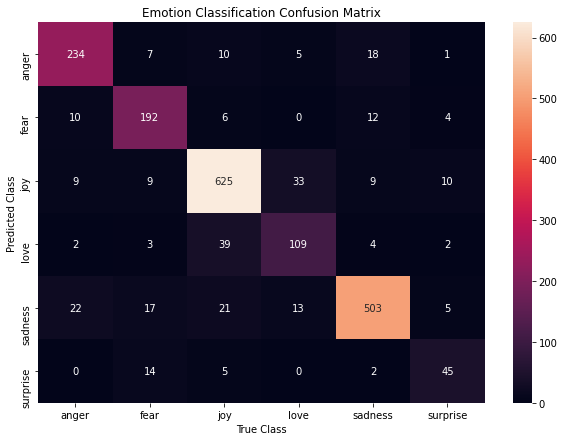

In [19]:
df_cm_svm_2 = pd.DataFrame(matrix_svm_2, index=["anger", "fear", "joy", "love", "sadness", "surprise"], columns=["anger", "fear", "joy", "love", "sadness", "surprise"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_svm_2,annot=True, fmt ="d")
plt.title('Emotion Classification Confusion Matrix')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')


In [20]:
print(report_2)

print("Accuracy:", accuracy_score(y_test_2, prediction_linear_2))

print("Recall:", recall_score(y_test_2, prediction_linear_2, average='weighted'))

print("Precision:", precision_score(y_test_2, prediction_linear_2, average='weighted'))

print("F1-score:", f1_score(y_test_2, prediction_linear_2, average='weighted'))


              precision    recall  f1-score   support

       anger       0.84      0.85      0.85       275
        fear       0.79      0.86      0.82       224
         joy       0.89      0.90      0.89       695
        love       0.68      0.69      0.68       159
     sadness       0.92      0.87      0.89       581
    surprise       0.67      0.68      0.68        66

    accuracy                           0.85      2000
   macro avg       0.80      0.81      0.80      2000
weighted avg       0.86      0.85      0.85      2000

Accuracy: 0.854
Recall: 0.854
Precision: 0.8556143857164777
F1-score: 0.8544255043030531


In [ ]:
import pickle
# pickling the vectorizer
pickle.dump(vectorizer, open('vectorizer.sav', 'wb'))
# pickling the model
pickle.dump(classifier_linear, open('classifier.sav', 'wb'))
